In [ ]:
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown
from matplotlib.ticker import MaxNLocator

#**Task 1: Acquire the data** #

##**Fashion MNIST** ##

In [ ]:
# Define data transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load the fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26421880/26421880 [00:01<00:00, 18443723.05it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 309660.62it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5464785.39it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14327987.39it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



###**Compute Mean & STD to use in Normalization process** ###

In [ ]:
def compute_mean_std(train_loader, test_loader):
    # Concatenate train and test datasets
    all_data = torch.cat([torch.cat([images for images, _ in loader], dim=0) for loader in (train_loader, test_loader)], dim=0)

    # Vectorize the images
    num_images, num_channels, height, width = all_data.size()
    all_data = all_data.view(num_images, -1)

    # Compute mean and std
    mean = all_data.mean(dim=0)
    std = all_data.std(dim=0)

    return mean, std

# Get mean and std
mean, std = compute_mean_std(train_loader, test_loader)

# Print mean and std
#print('Mean:', mean)
#print('Standard Deviation:', std)


###**Vectorize and Normalize Training & Test set** ###

In [ ]:
def vectorize_and_normalize(data_loader, mean=None, std=None):
    vectorized_data = []
    labels = []
    for images, targets in data_loader:
        # Vectorize the images
        batch_size, num_channels, height, width = images.size()
        images = images.view(batch_size, -1)

        if mean is not None and std is not None:
            # Normalize the images using the calculated mean and std
            images = (images - mean.view(1, -1)) / std.view(1, -1)

        vectorized_data.append(images)
        labels.append(targets)

    vectorized_data = torch.cat(vectorized_data, dim=0)
    labels = torch.cat(labels, dim=0)

    return vectorized_data, labels


# Vectorize and normalize the training and test data
train_data, train_labels = vectorize_and_normalize(train_loader, mean, std)
test_data, test_labels = vectorize_and_normalize(test_loader, mean, std)

# Vectorize training and test data, NO normalization
train_data_raw, train_labels_raw = vectorize_and_normalize(train_loader)
test_data_raw, test_labels_raw = vectorize_and_normalize(test_loader)

###**Display A Sample of Every Image Class in Fashion MNIST Dataset** ###

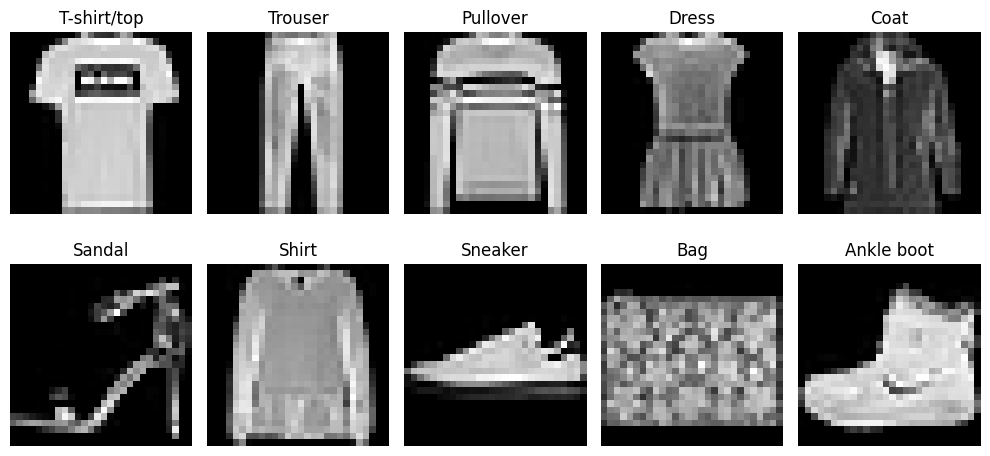

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

# Define data transformations and load the dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Create a dictionary to hold a sample image for each class
class_samples = {i: None for i in range(10)}

# Iterate through the dataset to find a sample image for each class
for image, label in train_dataset:
    # If we've found a sample for every class, break out of the loop
    if all(v is not None for v in class_samples.values()):
        break
    # Otherwise, save the first occurrence of each class to the dictionary
    if class_samples[label] is None:
        class_samples[label] = image

# List of class label names
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# Plot a sample image for each class
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(class_samples[i].squeeze(), cmap='gray')
    ax.set_title(class_names[i])
    ax.axis('off')
plt.tight_layout()  # Adjusts the spacing between plots
plt.show()


##**CIFAR-10** ##

In [ ]:
# Precise mean and standard deviation values for CIFAR-10
# AS PER https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data#:~:text=The%20precise%20values%20for%20cifar10%20train%20set,are%20mean%3A%200.49139968%2C%200.48215827%2C0.44653124%20std%3A%200.24703233%200.24348505%200.26158768
mean = (0.49139968, 0.48215827, 0.44653124)
std = (0.24703233, 0.24348505, 0.26158768)

# Define the transformation for normalizing and reshaping the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:03<00:00, 50460819.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


###**Display A Sample of Every Image Class in CIFAR-10 Dataset** ###

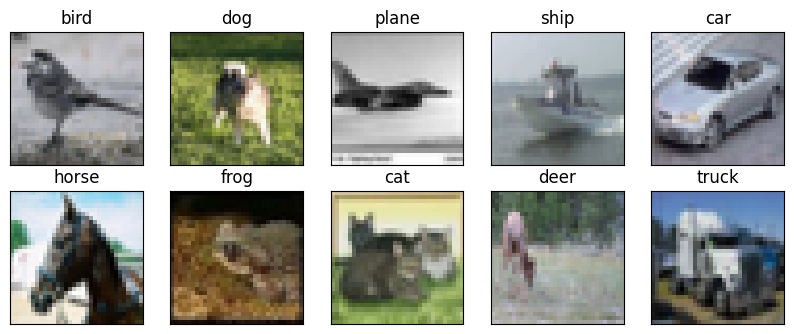

In [ ]:
# CIFAR-10 class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to show unique training images
def show_images():
    plt.figure(figsize=(10, 10))
    list_ = []
    y = 0
    for images, labels in trainloader:
        # Vectorize the images
        images = images.view(images.size(0), -1)
        for i in range(len(labels)):
            label_index = labels[i].item()
            if classes[label_index] not in list_:
                plt.subplot(5, 5, y + 1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                img = images[i].view(3, 32, 32).numpy()  # Reshape back to 3x32x32 for displaying
                img = np.array(std)[:, None, None] * img + np.array(mean)[:, None, None]  # De-normalize for displaying
                img = np.clip(img, 0, 1)  # Clip values to the range [0, 1]
                plt.imshow(np.transpose(img, (1, 2, 0)))
                plt.title(classes[label_index])
                list_.append(classes[label_index])
                y += 1
            if y >= 10:
                break
        if y >= 10:
            break
    plt.show()

# Call the function to show unique training images
show_images()

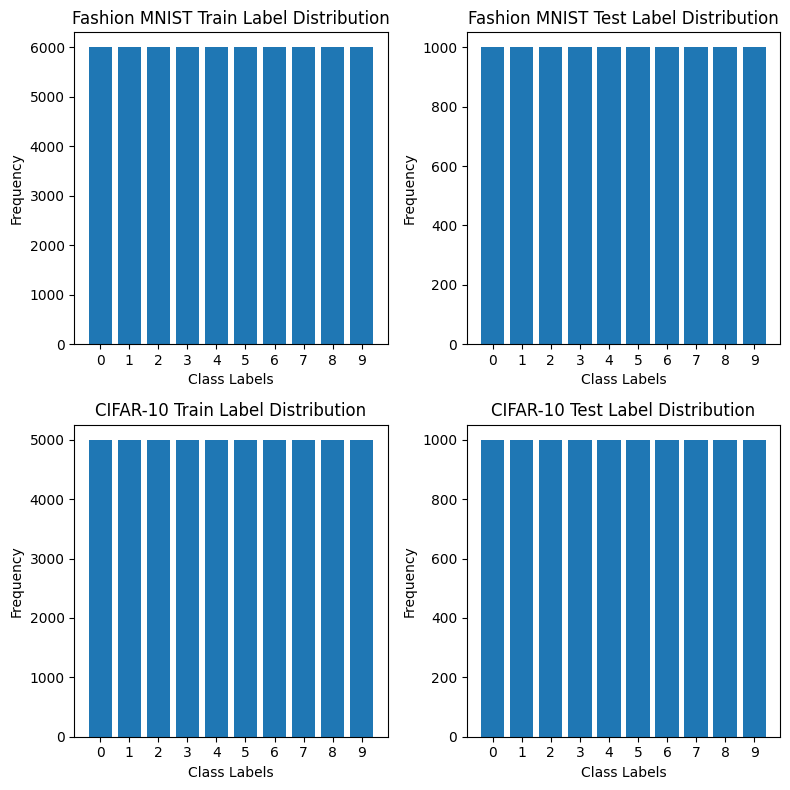

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# Function to plot label distribution
def plot_label_distribution(labels, title, ax):
    unique_labels, counts = np.unique(labels, return_counts=True)
    ax.bar(unique_labels, counts, tick_label=unique_labels)
    ax.set_title(title)
    ax.set_xlabel('Class Labels')
    ax.set_ylabel('Frequency')

# Get the labels for both datasets
fashion_mnist_train_labels = np.array([label for _, label in train_dataset])
fashion_mnist_test_labels = np.array([label for _, label in test_dataset])
cifar10_train_labels = np.array([label for _, label in trainset])
cifar10_test_labels = np.array([label for _, label in testset])

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Plot the label distributions
plot_label_distribution(fashion_mnist_train_labels, 'Fashion MNIST Train Label Distribution', axs[0, 0])
plot_label_distribution(fashion_mnist_test_labels, 'Fashion MNIST Test Label Distribution', axs[0, 1])
plot_label_distribution(cifar10_train_labels, 'CIFAR-10 Train Label Distribution', axs[1, 0])
plot_label_distribution(cifar10_test_labels, 'CIFAR-10 Test Label Distribution', axs[1, 1])

# Adjust the spacing
plt.tight_layout()
plt.show()


#**Task 2: Implement a Multilayer Perceptron** #

Implement the MLP as a python class. The constructor for the class should take as input the activation function
(e.g., ReLU), the number of hidden layers (e.g., 2) and the number of units in the hidden layers (e.g., [64, 64]) and
it should initialize the weights and biases (with an initializer of your choice, except where otherwise specified)
as well as other important properties of the MLP.

Helper functions to print a confusion matrix

In [ ]:
def confusion_matrix(y_true, y_pred, labels):
  # Initialize the confusion matrix
  confusion_matrix = [[0] * len(labels) for _ in range(len(labels))]

  # Populate the confusion matrix
  for actual, predicted in zip(y_true, y_pred):
      confusion_matrix[actual-1][predicted-1] += 1

  return np.array(confusion_matrix)

def print_confusion_matrix(conf_matrix, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actuals', fontsize=16)
    plt.title(title, fontsize=18)
    plt.show()

Activation functions and their derivatives

In [ ]:
# Sigmoid (logistic)
sigmoid = lambda x: 1/(1 + np.exp(-x))
sigmoid_prime = lambda x: x * (1 - x)

# Hyperbolic tangent
tanh = lambda x: np.tanh(x)
tanh_prime = lambda x: 1 - x ** 2

# ReLu
relu = lambda x: np.maximum(0, x)
relu_prime = lambda x: (x > 0).astype(float)

Multilayers Perceptron Class inspired from https://github.com/KirillShmilovich/MLP-Neural-Network-From-Scratch/blob/master/MLP.ipynb and class notes.

In [ ]:
class MLP():

  def __init__(self, activation_function, num_hidden, size_hidden, learning_rate, add_bias=True, batch_size=32, weight_init='xavier', l1=0.0, l2=0.0, learning_rate_decay=0, random_state=None):
    self.activation_function = activation_function
    self.num_hidden = num_hidden
    self.size_hidden = size_hidden
    self.add_bias = add_bias
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.weight_init = weight_init    # Weight initialization technique
    self.l1 = l1
    self.l2 = l2
    self.learning_rate_decay = learning_rate_decay
    self.random_state=random_state

    self.weights = []

    # Initialize empty arrays to store loss, accuracy
    self.train_loss = []
    self.train_acc = []
    self.test_loss = []
    self.test_acc = []

    # Set activation function and derivative
    if activation_function == "sigmoid":
      self.activation = sigmoid
      self.activation_prime = sigmoid_prime
    elif activation_function == "tanh":
        self.activation = tanh
        self.activation_prime = tanh_prime
    elif activation_function == "relu":
        self.activation = relu
        self.activation_prime = relu_prime

  # Softmax function
  def softmax(self, z):
    exp_z = np.exp(z - np.amax(z, axis=1, keepdims=True))      # Remove the max value to prevent overflow
    return exp_z / (np.sum(exp_z, axis=1, keepdims=True))

  def feed_forward(self, x):
    # Output of the first layer is simply x
    layer_output = x
    self.layers_outputs[0] = layer_output

    # Iterate through each layer
    for i, w in enumerate(self.weights):
      layer_output = self.activation(np.dot(layer_output, w))   # Compute output of next layer
      self.layers_outputs[i+1] = layer_output

    # Softmax on last layer output
    output = self.softmax(self.layers_outputs[-1])
    return output

  # Update the weights of the network through back-propagation
  def back_prop(self, y, yh, epoch):
    # Calculate the error at the output layer
    dy = (yh - y)

    if self.activation_function in ["sigmoid", "tanh"]:
      dy *= self.activation_prime(self.layers_outputs[-1])

    for i in range(1, len(self.weights)+1):
      x = self.layers_outputs[-i-1]

      # L1 regularization
      if self.l1 > 0:
        l1_regularization_term = self.l1/(2*self.batch_size) * (np.linalg.norm(self.weights[-i]))
      else:
        l1_regularization_term = 0

      # L2 regularization
      if self.l2 > 0:
        l2_regularization_term = self.l2/(2*self.batch_size) * (np.linalg.norm(self.weights[-i])**2)
      else:
        l2_regularization_term = 0

      # Learning rate decay
      if self.learning_rate_decay > 0:
        learning_rate = self.learning_rate / (1 + epoch * self.learning_rate_decay)
      else:
        learning_rate = self.learning_rate

      grad = np.dot(x.T, dy)/self.batch_size                  # Compute gradient
      self.weights[-i] -= learning_rate * (grad + l1_regularization_term + l2_regularization_term)          # Update weights
      dy = self.activation_prime(x) * (np.dot(dy, self.weights[-i].T))

  # Compute the multiclass cross-entropy loss
  # Takes one-hot encoding format
  def loss(self, y_pred, y):
    y_pred = np.clip(y_pred, 1e-20, 1 - 1e-20)  # Limit the range of y_pred to avoid log(0) or log(1)
    return ((-np.log(y_pred))*y).sum(axis=1).mean()/2

  # Init the weights given a technique
  def init_weights(self, technique):

    for i in range(self.layer_sizes.shape[0] - 1):
      input_size = self.layer_sizes[i]
      output_size = self.layer_sizes[i+1]

      if technique == "uniform":
        # Init the weights with random values from [-1,1] with std=1 and mean=0
        self.weights.append(np.random.uniform(-1, 1, size=(input_size, output_size)))
      elif technique == "zeros":
        # Init weights with all zeros
        self.weights.append(np.zeros(shape=(input_size, output_size)))
      elif technique == "gaussian":
        # Init weights with Gaussian N(0,1)
        self.weights.append(np.random.normal(size=(input_size, output_size)))
      elif technique == "xavier":
        # Init weights with normalized Xavier
        bound = np.sqrt(6.0 / (self.layer_sizes[i] + output_size))
        if self.random_state:
          self.weights.append(np.random.default_rng(seed=self.random_state).uniform(-bound, bound, size=(input_size, output_size)))
        else:
          self.weights.append(np.random.uniform(-bound, bound, size=(input_size, output_size)))
      elif technique == "kaiming":
        # Init weights with Kaiming
        std = np.sqrt(2.0 / self.layer_sizes[i])
        self.weights.append(np.random.normal(0, std, size=(input_size, output_size)))

  # Transform probabilities into labels by taking the max probability
  def prob_to_labels(self, y):
    y_hot = np.zeros((y.shape[0], y.shape[1]))
    y_hot[np.arange(y.shape[0]), y.argmax(axis=1)] = 1

    # Take max probability of every sample
    return np.argmax(y_hot, axis=1)

  # Make random batches of size N
  def make_batches(self, X, y, N):
    if self.random_state:
      n = np.random.default_rng(seed=self.random_state).permutation(N)
    else:
      n = np.random.permutation(N)
    X_batches = np.array_split(X[n], N/self.batch_size)
    Y_batches = np.array_split(y[n], N/self.batch_size)
    return X_batches, Y_batches

  def fit(self, X, X_test, y, y_test, epochs, early_exit=0, verbose=False):
    self.epochs = epochs
    self.X = X
    self.Y = y
    N, D = X.shape      # N = number of samples (60000), D = length of sample (28x28=784)

    # One-hot encode the labels
    num_classes = len(np.unique(y))             # number of classes
    y = np.eye(num_classes)[y]                  # one-hot encoding of y
    y_test = np.eye(num_classes)[y_test]        # one-hot encoding of y_test

    # Add bias
    if self.add_bias:
      X = np.concatenate((X, np.ones((N,1))), axis=1)
      X_test = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)
      N, D = X.shape

    # Create array that holds the size of every layer: [input_l, hidden_l1, hidden_l2, ..., hidden_ln, output_l]
    self.layer_sizes = np.array([D] + self.size_hidden + [y.shape[1]])

    # Initialize the weights
    self.init_weights(self.weight_init)

    for epoch in range(epochs):

      # Init layers outputs
      self.layers_outputs = [np.empty((self.batch_size, layer)) for layer in self.layer_sizes]    # List of empty arrays used to hold hidden layer outputs

      # Init train loss and accuracy
      train_loss = 0
      train_acc = 0

      # Make batches
      X_batches, Y_batches = self.make_batches(X, y, N)

      for batch_x, batch_y in zip(X_batches, Y_batches):
        yh = self.feed_forward(batch_x)
        train_loss += self.loss(yh, batch_y)
        train_acc += self.evaluate_acc(self.prob_to_labels(yh), self.prob_to_labels(batch_y))
        self.back_prop(batch_y, yh, epoch)

      self.train_loss.append(train_loss/len(X_batches))
      self.train_acc.append(train_acc/len(X_batches))

      # Compute loss and accuracy on test dataset
      self.layers_outputs = [np.empty((N, layer)) for layer in self.layer_sizes]
      output_y = self.feed_forward(X_test)
      test_loss = self.loss(output_y, y_test)
      test_acc = self.evaluate_acc(self.prob_to_labels(output_y), self.prob_to_labels(y_test))
      self.test_loss.append(test_loss)
      self.test_acc.append(test_acc)

      if test_acc < early_exit:
        # exit fit function if accuracy is lower early_exit value
        break

    if verbose == True:
      self.print_metrics()

  def predict(self, X):
    # Add bias
    if self.add_bias:
      X = np.concatenate((X, np.ones((X.shape[0] ,1))), axis=1)

    # Feed the data to the MLP
    self.output_layers = [np.empty((X.shape[0], layer)) for layer in self.layer_sizes]
    output = self.feed_forward(X)

    return self.prob_to_labels(output) # Return labels

  # Accuracy by comparing labels of 2 arrays
  def evaluate_acc(self, y_pred, y):
    return np.sum(y_pred == y)/len(y)

  # Prints a table of the metrics of epochs
  def print_metrics(self):
    # Create dataframe to display metrics in a table
    metrics_rows = [[i+1, self.train_loss[i], self.test_loss[i], self.train_acc[i], self.test_acc[i]] for i in range(self.epochs)]
    metrics_df = pd.DataFrame(metrics_rows, columns=["Epochs", "Training Loss", "Test Loss", "Training Accuracy", "Test Accuracy"])
    metrics_df = metrics_df.round(4)
    styled_df = metrics_df.style.hide(axis="index").set_properties(**{'text-align': 'left'})
    styled_df.set_caption("Metrics of MLP fitting over epochs")
    styled_df.format({'int_column': '{:.0f}'})
    styled_df.format(precision=4)
    display(styled_df)


In [ ]:
# Test 3 models

model = MLP(activation_function="sigmoid", num_hidden=1, size_hidden=[128], learning_rate=1, random_state=100)
model.fit(X=train_data, X_test=test_data, y=train_labels, y_test=test_labels, epochs=15, verbose=True)
predictions = model.predict(X=test_data)
print(model.evaluate_acc(predictions, test_labels.numpy()))

model = MLP(activation_function="relu", num_hidden=1, size_hidden=[128], learning_rate=0.005, random_state=100)
model.fit(X=train_data, X_test=test_data, y=train_labels, y_test=test_labels, epochs=15, verbose=True)
predictions = model.predict(X=test_data)
print(model.evaluate_acc(predictions, test_labels.numpy()))

model = MLP(activation_function="tanh", num_hidden=1, size_hidden=[128], learning_rate=0.05, random_state=100)
model.fit(X=train_data, X_test=test_data, y=train_labels, y_test=test_labels, epochs=15, verbose=True)
predictions = model.predict(X=test_data)
print(model.evaluate_acc(predictions, test_labels.numpy()))

Epochs,Training Loss,Test Loss,Training Accuracy,Test Accuracy
1,0.8049,0.7929,0.7907,0.8218
2,0.7837,0.7863,0.8464,0.8430
3,0.7777,0.7832,0.8594,0.8505
4,0.7742,0.7815,0.8656,0.8549
5,0.7717,0.7807,0.8708,0.8577
6,0.7697,0.7802,0.8738,0.8584
7,0.7680,0.7798,0.8767,0.8597
8,0.7666,0.7794,0.8795,0.8614
9,0.7654,0.7791,0.8817,0.8629
10,0.7642,0.7787,0.8835,0.8635


0.8677


Epochs,Training Loss,Test Loss,Training Accuracy,Test Accuracy
1,0.3020,0.2433,0.7943,0.8278
2,0.2145,0.2210,0.8492,0.8430
3,0.1955,0.2103,0.8626,0.8491
4,0.1839,0.2032,0.8697,0.8543
5,0.1755,0.1982,0.8747,0.8581
6,0.1688,0.1943,0.8792,0.8617
7,0.1633,0.1910,0.8827,0.8642
8,0.1584,0.1883,0.8864,0.8661
9,0.1541,0.1860,0.8896,0.8686
10,0.1502,0.1840,0.8924,0.8697


0.8737


Epochs,Training Loss,Test Loss,Training Accuracy,Test Accuracy
1,0.5734,0.5293,0.7670,0.8292
2,0.5098,0.5142,0.8511,0.8460
3,0.4960,0.5079,0.8640,0.8549
4,0.4881,0.5043,0.8722,0.8609
5,0.4825,0.5021,0.8776,0.8637
6,0.4780,0.5008,0.8822,0.8649
7,0.4743,0.4999,0.8856,0.8647
8,0.4710,0.4994,0.8886,0.8651
9,0.4681,0.4989,0.8920,0.8659
10,0.4655,0.4984,0.8946,0.8675


0.8714


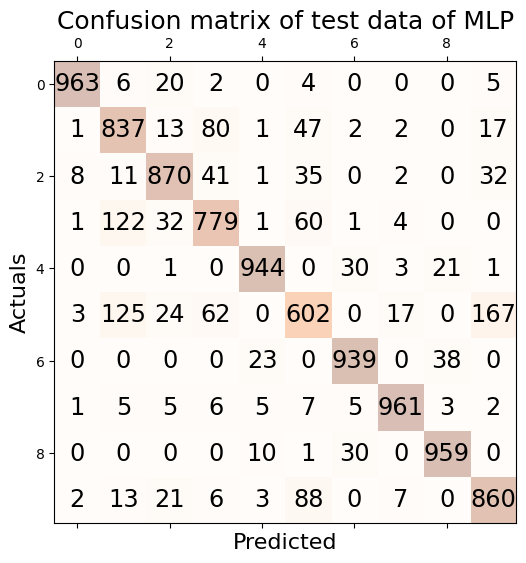

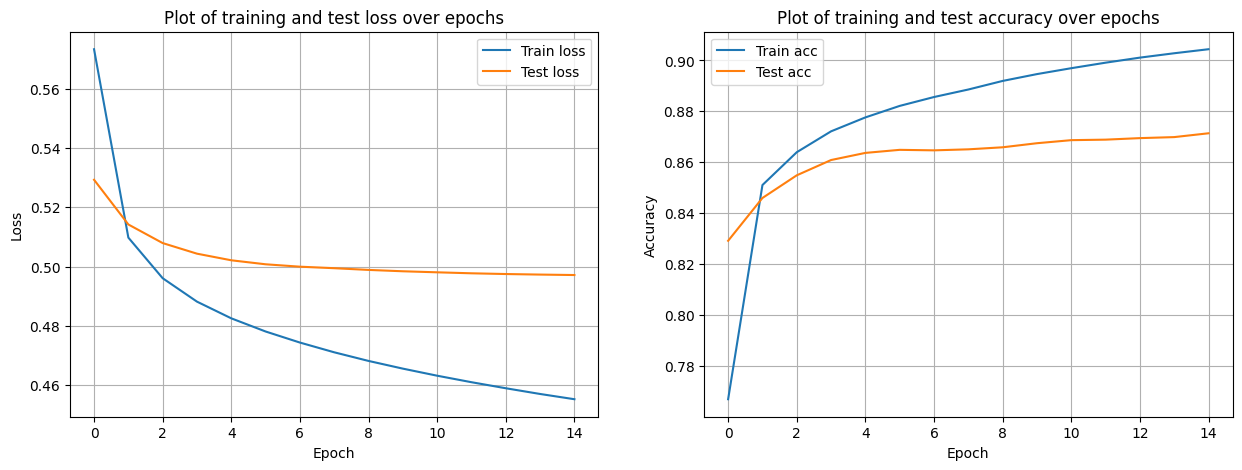

In [ ]:
test_conf_matrix = confusion_matrix(test_labels, predictions, [i for i in range(10)])
print_confusion_matrix(test_conf_matrix, "Confusion matrix of test data of MLP")

fig,ax = plt.subplots(1, 2, figsize=(15,5))
epochs_range = range(model.epochs)

# Plot of training and test loss over epochs
ax[0].plot(epochs_range, model.train_loss, label="Train loss")
ax[0].plot(epochs_range, model.test_loss, label="Test loss")
ax[0].legend()
ax[0].set_title("Plot of training and test loss over epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].grid()

# Plot of training and test accuracy over epochs
ax[1].plot(epochs_range, model.train_acc,label="Train acc")
ax[1].plot(epochs_range, model.test_acc,label="Test acc")
ax[1].legend()
ax[1].set_title("Plot of training and test accuracy over epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].grid()

**Optimize the hyperparameters**

---

Let's optimize the learning rate and the learning rate decay using exaustive grid search and 10 epochs.

This is a function to perform the optimization with a simple parameters grid.

In [ ]:
def find_best_learning_params(activation_function, num_hidden, size_hidden):

  param_grid = {'learning_rate': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001],
                'learning_rate_decay': [0, 0.01, 0.001, 0.0001, 0.00001]}

  best_acc = 0
  best_parameters = {'learning_rate': None,
                      'learning_rate_decay': None}

  # Iterate through all combinations of hyperparameters
  for learning_rate in param_grid['learning_rate']:
    for learning_rate_decay in param_grid['learning_rate_decay']:
      model = MLP(activation_function=activation_function, num_hidden=num_hidden, size_hidden=size_hidden, learning_rate=learning_rate, learning_rate_decay=learning_rate_decay, random_state=100)
      model.fit(X=train_data, X_test=test_data, y=train_labels, y_test=test_labels, epochs=10, early_exit=0.5)
      predictions = model.predict(X=test_data)
      acc = model.evaluate_acc(predictions, test_labels.numpy())

      # Check if the current combination is the best so far
      if acc > best_acc:
        best_acc = acc
        best_parameters = {
          'learning_rate': learning_rate,
          'learning_rate_decay': learning_rate_decay
        }
  return best_parameters, best_acc

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
best_params, best_acc = find_best_learning_params('relu', 0, [])
# Print the best parameters and best accuracy
display(Markdown("**ReLu 0 hidden layer:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

**ReLu 0 hidden layer:**

Best Parameters: {'learning_rate': 0.01, 'learning_rate_decay': 0.01}
Best Accuracy: 0.8418


In [ ]:
best_params, best_acc = find_best_learning_params('relu', 1, [128])
# Print the best parameters and best accuracy
display(Markdown("**ReLu 1 hidden layer:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

**ReLu 1 hidden layer:**

Best Parameters: {'learning_rate': 0.01, 'learning_rate_decay': 0}
Best Accuracy: 0.8747


In [ ]:
best_params, best_acc = find_best_learning_params('relu', 2, [128, 128])
# Print the best parameters and best accuracy
display(Markdown("**ReLu 2 hidden layers:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

**ReLu 2 hidden layers:**

Best Parameters: {'learning_rate': 0.005, 'learning_rate_decay': 0.01}
Best Accuracy: 0.8739


In [ ]:
best_params, best_acc = find_best_learning_params('sigmoid', 2, [128, 128])
# Print the best parameters and best accuracy
display(Markdown("**Sigmoid 2 hidden layers:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

**Sigmoid 2 hidden layers:**

Best Parameters: {'learning_rate': 1, 'learning_rate_decay': 0.0001}
Best Accuracy: 0.8662


In [ ]:
best_params, best_acc = find_best_learning_params('tanh', 2, [128, 128])
# Print the best parameters and best accuracy
display(Markdown("**Tanh 2 hidden layer:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

**Tanh 2 hidden layer:**

Best Parameters: {'learning_rate': 0.1, 'learning_rate_decay': 0.01}
Best Accuracy: 0.8723


In [ ]:
warnings.filterwarnings('default')

## Task 3 Run the experiments and report

The goal of the experiments in this part is to have you explore the consequences of important decisions made while
training neural networks. Split the dataset into training and test sets. Use test set to estimate performance in all of the
experiments after training the model with training set. Evaluate the performance using accuracy. You are welcome
to perform any experiments and analyses you see fit (e.g., the effect of data augmentation / dropout regularization /
number of hidden layers / . . . on accuracy), but at a minimum you must complete the following experiments in the
order stated below:

###1.
First of all, experiment with initializing your model weights in a few different ways. Create several MLPs with
a single hidden layer having 128 units, initializing the weights as <br>
(1) all zeros
(2) Uniform [-1, 1]
(3) Gaussian N(0,1)
(4) Xavier
(5) Kaiming.
After training these models, compare the effect of weight initialization on the training curves and test accuracy on the Fashion MNIST dataset.

In [ ]:
# Set the same parameters for all model
activation_function = "relu"
num_hidden = 1
size_hidden = [128]
learning_rate = 0.01
learning_rate_decay = 0.01
epochs = 10
random_state = 100

display(Markdown("**Accuracy of models with different weights initialization techniques**"))

# (1) All zeros
model = MLP(activation_function, num_hidden, size_hidden, learning_rate, learning_rate_decay=learning_rate_decay, weight_init="zeros", random_state=random_state)
model.fit(train_data, test_data, train_labels, test_labels, epochs)
predictions = model.predict(test_data)
acc = model.evaluate_acc(predictions, test_labels.numpy())
print("All zeros: ", acc)

# (2) Uniform [-1, 1]
model = MLP(activation_function, num_hidden, size_hidden, learning_rate, learning_rate_decay=learning_rate_decay, weight_init="uniform", random_state=random_state)
model.fit(train_data, test_data, train_labels, test_labels, epochs)
predictions = model.predict(test_data)
acc = model.evaluate_acc(predictions, test_labels.numpy())
print("Uniform: ", acc)

# (3) Gaussian N(0, 1)
model = MLP(activation_function, num_hidden, size_hidden, learning_rate, learning_rate_decay=learning_rate_decay, weight_init="gaussian", random_state=random_state)
model.fit(train_data, test_data, train_labels, test_labels, epochs)
predictions = model.predict(test_data)
acc = model.evaluate_acc(predictions, test_labels.numpy())
print("Gaussian: ", acc)

# (4) Normalized Xavier
model = MLP(activation_function, num_hidden, size_hidden, learning_rate, learning_rate_decay=learning_rate_decay, weight_init="xavier", random_state=random_state)
model.fit(train_data, test_data, train_labels, test_labels, epochs)
predictions = model.predict(test_data)
acc = model.evaluate_acc(predictions, test_labels.numpy())
print("Xavier: ", acc)

# (5) Kaiming
model = MLP(activation_function, num_hidden, size_hidden, learning_rate, learning_rate_decay=learning_rate_decay, weight_init="kaiming", random_state=random_state)
model.fit(train_data, test_data, train_labels, test_labels, epochs)
predictions = model.predict(test_data)
acc = model.evaluate_acc(predictions, test_labels.numpy())
print("Kaiming: ", acc)

**Accuracy of models with different weights initialization techniques**

All zeros:  0.1
Uniform:  0.7373
Gaussian:  0.7507
Xavier:  0.8742
Kaiming:  0.8769


###2.
Create three different models:
(1) an MLP with no hidden layers, i.e., it directly maps the inputs to outputs,
(2)an MLP with a single hidden layer having 128 units and ReLU activations,
(3) an MLP with 2 hidden layers
each having 128 units with ReLU activations. It should be noted that since we want to perform classification, all
of these models should have a softmax layer at the end. After training, compare the test accuracy of these three
models on the Fashion MNIST dataset. Comment on how non-linearity and network depth affects the accuracy.
Are the results that you obtain expected?

In [ ]:
# Set the same parameters for all model
activation_function = "relu"
epochs = 10
random_state=100

display(Markdown("**Accuracy of models with 0, 1 and 2 hidden layers (using optimized hyperparameters)**"))

# (1) MLP with no hidden layers
model = MLP(activation_function, num_hidden=0, size_hidden=[], learning_rate=0.01, learning_rate_decay=0.001, random_state=random_state)
model.fit(train_data, test_data, train_labels, test_labels, epochs)
predictions = model.predict(X=test_data)
acc = model.evaluate_acc(predictions, test_labels.numpy())
print("0 hidden layer: ", acc)

# (2) MLP with 1 hidden layers of 128 units, ReLu activation function
model = MLP(activation_function, num_hidden=1, size_hidden=[128], learning_rate=0.01, learning_rate_decay=0.01, random_state=random_state)
model.fit(train_data, test_data, train_labels, test_labels, epochs)
predictions = model.predict(X=test_data)
acc = model.evaluate_acc(predictions, test_labels.numpy())
print("1 hidden layer: ", acc)

# (3) MLP with 2 hidden layers of 128 units, ReLu activation function
model = MLP(activation_function, num_hidden=2, size_hidden=[128, 128], learning_rate=0.005, learning_rate_decay=0.001, random_state=random_state)
model.fit(train_data, test_data, train_labels, test_labels, epochs)
predictions = model.predict(X=test_data)
relu_2h_acc = model.evaluate_acc(predictions, test_labels.numpy())
print("2 hidden layers: ", relu_2h_acc)

**Accuracy of models with 0, 1 and 2 hidden layers (using optimized hyperparameters)**

0 hidden layer:  0.8412
1 hidden layer:  0.8742
2 hidden layers:  0.8731


###3.
Take the last model above, the one with 2 hidden layers, and create two different copies of it in which you pick
two activations of your choice (except ReLU) from the course slides. After training these two models on Fashion
MNIST compare their test accuracies with the model with ReLU activations. Comment on the performances of
these models: which one is better and why? Are certain activations better than others? If the results are not as
you expected, what could be the reason?


In [ ]:
# Set the same parameters for all model
epochs = 10

display(Markdown("**Accuracy of models with ReLu, sigmoid and tanh activation functions**"))

print("ReLu: ", relu_2h_acc)

# Sigmoid
model = MLP(activation_function="sigmoid", num_hidden=2, size_hidden=[128, 128], learning_rate=1, learning_rate_decay=1e-05, random_state=random_state)
model.fit(X=train_data, X_test=test_data, y=train_labels, y_test=test_labels, epochs=epochs)
predictions = model.predict(X=test_data)
acc = model.evaluate_acc(predictions, test_labels.numpy())
print("Sigmoid: ", acc)

# Tanh
model = MLP(activation_function="tanh", num_hidden=2, size_hidden=[128, 128], learning_rate=0.1, learning_rate_decay=0.001, random_state=random_state)
model.fit(X=train_data, X_test=test_data, y=train_labels, y_test=test_labels, epochs=epochs)
predictions = model.predict(X=test_data)
acc = model.evaluate_acc(predictions, test_labels.numpy())
print("Tanh: ", acc)

**Accuracy of models with ReLu, sigmoid and tanh activation functions**

ReLu:  0.8731
Sigmoid:  0.8655
Tanh:  0.8711


###4.
Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above.
However, this
time, independently add L1 and L2 regularization to the network and train the MLP in this way. How do theseregularizations affect the accuracy? (This proportion can be varied as a tunable hyperparameter that can be
explored as part of other project requirements)

In [ ]:
def find_best_reg_params(param_grid):

  best_acc = 0
  best_parameters = {'l1': None,
                      'l2': None}

  # Iterate through all combinations of hyperparameters
  for l1 in param_grid['l1']:
    for l2 in param_grid['l2']:
      model = MLP(activation_function='relu', num_hidden=2, size_hidden=[128,128], learning_rate=0.005, learning_rate_decay=0.001, l1=l1, l2=l2, random_state=100)
      model.fit(X=train_data, X_test=test_data, y=train_labels, y_test=test_labels, epochs=10, early_exit=0.5)
      predictions = model.predict(X=test_data)
      acc = model.evaluate_acc(predictions, test_labels.numpy())

      # Check if the current combination is the best so far
      if acc > best_acc:
        best_acc = acc
        best_parameters = {
          'l1': l1,
          'l2': l2
        }
  return best_parameters, best_acc

In [ ]:
param_grid = {'l1': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001],
              'l2': [0]}

best_params, best_acc = find_best_reg_params(param_grid)
# Print the best parameters and best accuracy
display(Markdown("**Only L1:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

<ipython-input-11-dcf917bf192e>:85: RuntimeWarning: invalid value encountered in multiply
  dy = self.activation_prime(x) * (np.dot(dy, self.weights[-i].T))
<ipython-input-11-dcf917bf192e>:37: RuntimeWarning: invalid value encountered in subtract
  exp_z = np.exp(z - np.amax(z, axis=1, keepdims=True))      # Remove the max value to prevent overflow


**Only L1:**

Best Parameters: {'l1': 5e-05, 'l2': 0}
Best Accuracy: 0.8742


In [ ]:
param_grid = {'l1': [0],
              'l2': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]}

best_params, best_acc = find_best_reg_params(param_grid)
# Print the best parameters and best accuracy
display(Markdown("**Only L2:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

<ipython-input-11-dcf917bf192e>:85: RuntimeWarning: invalid value encountered in multiply
  dy = self.activation_prime(x) * (np.dot(dy, self.weights[-i].T))
<ipython-input-11-dcf917bf192e>:37: RuntimeWarning: invalid value encountered in subtract
  exp_z = np.exp(z - np.amax(z, axis=1, keepdims=True))      # Remove the max value to prevent overflow


**Only L2:**

Best Parameters: {'l1': 0, 'l2': 1e-05}
Best Accuracy: 0.8721


In [ ]:
param_grid = {'l1': [0.0005, 0.0001, 0.00005,0.00001],
              'l2': [0.0005, 0.0001, 0.00005, 0.00001, 0.000005, 0.000001]}

best_params, best_acc = find_best_reg_params(param_grid)
# Print the best parameters and best accuracy
display(Markdown("**L1 and L2:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

<ipython-input-11-dcf917bf192e>:85: RuntimeWarning: invalid value encountered in multiply
  dy = self.activation_prime(x) * (np.dot(dy, self.weights[-i].T))
<ipython-input-11-dcf917bf192e>:37: RuntimeWarning: invalid value encountered in subtract
  exp_z = np.exp(z - np.amax(z, axis=1, keepdims=True))      # Remove the max value to prevent overflow


**L1 and L2:**

Best Parameters: {'l1': 5e-05, 'l2': 1e-06}
Best Accuracy: 0.8732


In [ ]:
display(Markdown("**Accuracy of models with l1 and l2 independently**"))

print("Without regularization: ", relu_2h_acc)

# L1 only
model = MLP(activation_function, num_hidden=2, size_hidden=[128, 128], learning_rate=0.005, learning_rate_decay=0.001, random_state=random_state, l1=5e-05)
model.fit(train_data, test_data, train_labels, test_labels, epochs)
predictions = model.predict(X=test_data)
acc = model.evaluate_acc(predictions, test_labels.numpy())
print("With l1 only: ", acc)

# L2 only
model = MLP(activation_function, num_hidden=2, size_hidden=[128, 128], learning_rate=0.005, learning_rate_decay=0.001, random_state=random_state, l2=1e-05)
model.fit(train_data, test_data, train_labels, test_labels, epochs)
predictions = model.predict(X=test_data)
acc = model.evaluate_acc(predictions, test_labels.numpy())
print("with l2 only: ", acc)

# L1 and L2
model = MLP(activation_function, num_hidden=2, size_hidden=[128, 128], learning_rate=0.005, learning_rate_decay=0.001, random_state=random_state, l1=5e-05, l2=1e-06)
model.fit(train_data, test_data, train_labels, test_labels, epochs)
predictions = model.predict(X=test_data)
acc = model.evaluate_acc(predictions, test_labels.numpy())
print("With l1 and l2: ", acc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Accuracy of models with l1 and l2 independently**

Without regularization:  0.8731
With l1 only:  0.8742
with l2 only:  0.8721
With l1 and l2:  0.8732


###5.
Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above. However, this time,
train it with unnormalized images. How does this affect the accuracy?


In [ ]:
display(Markdown("**Accuracy of models with normalized and unnormalized data**"))

print("Normalized: ", relu_2h_acc)

model = MLP(activation_function, num_hidden=2, size_hidden=[128, 128], learning_rate=0.001, learning_rate_decay=0.01, random_state=100)
model.fit(train_data_raw, test_data_raw, train_labels_raw, test_labels_raw, epochs)
predictions = model.predict(X=test_data_raw)
acc = model.evaluate_acc(predictions, test_labels.numpy())
print("Unnormalized: ", acc)

**Accuracy of models with normalized and unnormalized data**

Normalized:  0.8731
Unnormalized:  0.8182


###6.
Using PyTorch, create a convolutional neural network (CNN) with 2 convolutional and 2 fully connected layers.
Although you are free in your choice of the hyperparameters of the convolutional layers, set the number of units
in the fully connected layers to be 128. Also, set the activations in all of the layers to be ReLU. Train this CNN
on the Fashion MNIST dataset. Does using a CNN increase/decrease the accuracy compared to using MLPs?
Provide comments on your results.

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Setting up CUDA device for GPU training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Defining CNN Model**

In [ ]:
#The difinition of the convolutional net work is inspired by
#the official page of PyTorch and their way of defining a convolutional net wwrok
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    # Convolutional Layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

    # Fully Connected Layers
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 10)  # 10 classes in Fashion MNIST

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = nn.functional.max_pool2d(x, kernel_size=2)

    x = nn.functional.relu(self.conv2(x))
    x = nn.functional.max_pool2d(x, kernel_size=2)

    x = x.view(x.size(0), -1)  # Flatten the tensor

    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)

    return x

model = Net().to(device)



**Training CNN model**

Epoch 1, Loss: 0.6563658005631793
Epoch 2, Loss: 0.5401761709995891
Epoch 3, Loss: 0.4675545323559124
Epoch 4, Loss: 0.406847742251585
Epoch 5, Loss: 0.3508751558621064
Epoch 6, Loss: 0.30523514079437364
Epoch 7, Loss: 0.25512228816535676
Epoch 8, Loss: 0.2174151943906632
Epoch 9, Loss: 0.18442147738522674
Epoch 10, Loss: 0.15912487286907742


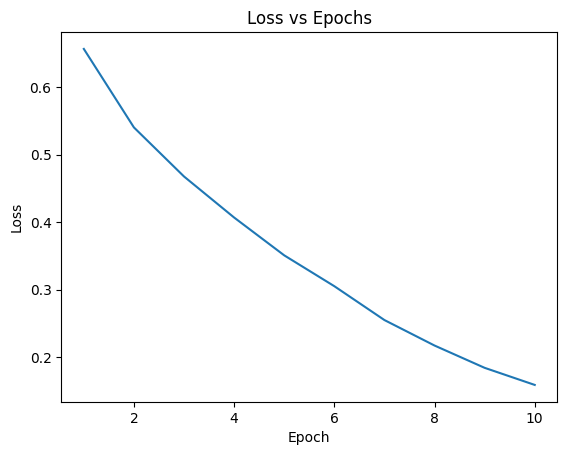

In [ ]:
#reference: https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Setting up the loss and optimizer
criterion = nn.CrossEntropyLoss()
#the two beta parameters in adams is implicitly set as
#beta1 = 0.9 for the momentum term
#beta2 = 0.999 for the RMSprop term
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize the epoch_losses list
epoch_losses = []

# Training Loop
for epoch in range(10):  # Training for 10 epochs for demonstration
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = model(inputs)
        #calculate the difference between the model's predictions and the actual data.
        loss = criterion(outputs, labels)
        loss.backward()
        #update the model parameters using the information in the gradients.
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")


# Plotting
plt.plot(range(1, 11), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()


**Evaluating the model's accuracy**


In [ ]:
#implementation inspired by: https://stackoverflow.com/questions/51503851/calculate-the-accuracy-every-epoch-in-pytorch
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test images: {100 * correct / total}%")


Accuracy of the model on the test images: 91.69%


###7.
Now using the CIFAR-10 dataset, train an MLP using your implementation
(with whatever layer dimensions
you like), and a CNN with the same architecture restrictions as in (6). How does using a CNN increase/decrease
the accuracy compared to using MLPs on this dataset?

Modified the previous find_best_learning_params and use it for CIFAR-10 datasets instead of the fashion MNIST data set and find the best parameters for the MLP training for CIFAR-10 dataset.

In [ ]:
mean = 0.5
std = 0.5

mean_tensor = torch.tensor([0.5])
std_tensor = torch.tensor([0.5])

def split_data_and_labels(dataloader, mean=None, std=None):
  data = []
  labels = []
  for images, targets in dataloader:
    # Vectorize the images
    batch_size, num_channels, height, width = images.size()
    images = images.view(batch_size, -1)
    if mean is not None and std is not None:
      # Normalize the images using the calculated mean and std
      images = (images - mean.view(1, -1)) / std.view(1, -1)

    data.append(images)
    labels.append(targets)

  data = torch.cat(data, dim=0)
  labels = torch.cat(labels, dim=0)

  return data, labels

traindata, trainlabels = split_data_and_labels(trainloader, mean_tensor, std_tensor)
testdata, testlabels = split_data_and_labels(testloader, mean_tensor, std_tensor)

In [ ]:
def find_best_params_CIFARTEN(activation_function, num_hidden, size_hidden):

  param_grid = {'learning_rate': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001],
                'learning_rate_decay': [0, 0.01, 0.001, 0.0001, 0.00001]}

  best_acc = 0
  best_parameters = {'learning_rate': None,
                      'learning_rate_decay': None}

  # Iterate through all combinations of hyperparameters
  for learning_rate in param_grid['learning_rate']:
    for learning_rate_decay in param_grid['learning_rate_decay']:
      model = MLP(activation_function=activation_function, num_hidden=num_hidden, size_hidden=size_hidden, learning_rate=learning_rate, learning_rate_decay=learning_rate_decay, random_state=100)
      model.fit(X=traindata, X_test=testdata, y=trainlabels, y_test=testlabels, epochs=10, early_exit=0.5)
      predictions = model.predict(X=testdata)
      acc = model.evaluate_acc(predictions, testlabels.numpy())

      # Check if the current combination is the best so far
      if acc > best_acc:
        best_acc = acc
        best_parameters = {
          'learning_rate': learning_rate,
          'learning_rate_decay': learning_rate_decay
        }
  return best_parameters, best_acc

In [ ]:
best_params, best_acc = find_best_params_CIFARTEN('sigmoid', 2, [128,128])
# Print the best parameters and best accuracy
display(Markdown("**Sigmoid 2 hidden layers:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

**Sigmoid 2 hidden layers:**

Best Parameters: {'learning_rate': 0.5, 'learning_rate_decay': 0}
Best Accuracy: 0.3599


In [ ]:
best_params, best_acc = find_best_params_CIFARTEN('relu', 2, [128,128])
# Print the best parameters and best accuracy
display(Markdown("**relu 2 hidden layers:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

**relu 2 hidden layers:**

Best Parameters: {'learning_rate': 0.001, 'learning_rate_decay': 0}
Best Accuracy: 0.3885


In [ ]:
best_params, best_acc = find_best_params_CIFARTEN('tanh', 2, [128,128])
# Print the best parameters and best accuracy
display(Markdown("**relu 2 hidden layers:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

**relu 2 hidden layers:**

Best Parameters: {'learning_rate': 0.01, 'learning_rate_decay': 0}
Best Accuracy: 0.3815


In [ ]:
best_params, best_acc = find_best_params_CIFARTEN('sigmoid', 1, [128])
# Print the best parameters and best accuracy
display(Markdown("**Sigmoid 1 hidden layers:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

**Sigmoid 2 hidden layers:**

Best Parameters: {'learning_rate': 0.1, 'learning_rate_decay': 0}
Best Accuracy: 0.3922


In [ ]:
best_params, best_acc = find_best_params_CIFARTEN('tanh', 1, [128])
# Print the best parameters and best accuracy
display(Markdown("**tanh 1 hidden layers:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

**tanh 1 hidden layers:**

Best Parameters: {'learning_rate': 0.01, 'learning_rate_decay': 0}
Best Accuracy: 0.3791


In [ ]:
best_params, best_acc = find_best_params_CIFARTEN('relu', 1, [128])
# Print the best parameters and best accuracy
display(Markdown("**relu 1 hidden layers:**"))
print("Best Parameters:", best_params)
print("Best Accuracy:", best_acc)

**tanh 1 hidden layers:**

Best Parameters: {'learning_rate': 0.001, 'learning_rate_decay': 0}
Best Accuracy: 0.3941


So the one that has the highest accuracy is the one with the ReLU activation function with 1 layer and hidden size of [128]. The highest accuracy that is found with MLP is 0.3941.

For a CNN, you would typically retain the 3D structure of the images and just normalize them

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

#this is an almost identical implementation as the one in Q3.6

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        #convolutional layers
        #There are other implementation that is possible for this purpose
        #But we are running out of time for the model to rerun so the alternative
        #implementation is commented.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        #self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        #self.bn2 = nn.BatchNorm2d(64)
        #The batch normalization can in fact improve the speed of the training and
        #reduce the sensitivities
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #here, instead of only using relu, we could have implemented
        #leaky relu, softmax, etc
        #the fact that different non-linear activation function is involves
        #will help the model captures more aspects of the input features.
        #but this performs ok, so we did not change.
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#We named each of the model differently since they used different optimizers.
model_CNN = CNN().to(device)
model_CNN_adams = CNN().to(device)
model_CNN_SGD = CNN().to(device)
model_CNN_SGD_moment = CNN().to(device)
model_CNN_SGD_moment_high = CNN().to(device)

Epoch 1, Loss: 1.3143745147816055
Epoch 2, Loss: 0.9431742348939257
Epoch 3, Loss: 0.7868088548598082
Epoch 4, Loss: 0.6810822646178858
Epoch 5, Loss: 0.587616565530105
Epoch 6, Loss: 0.5043130443262323
Epoch 7, Loss: 0.42523127464610905
Epoch 8, Loss: 0.35791096016955193
Epoch 9, Loss: 0.2853771568183094
Epoch 10, Loss: 0.23147067041291147


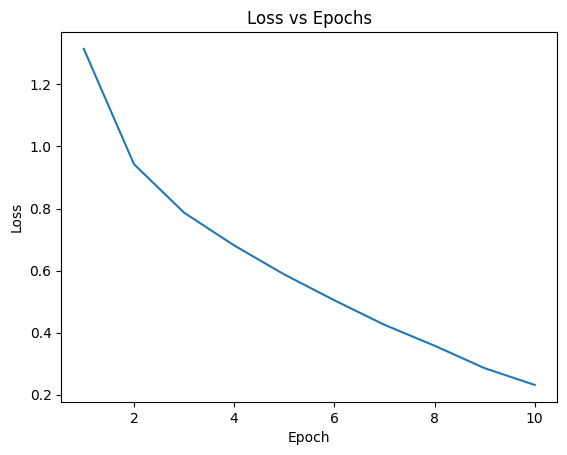

In [ ]:
# Setting up the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)

# Initialize list to store losses
epoch_losses = []
# Training Loop
for epoch in range(10):  # Training for 10 epochs for demonstration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = model_CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")


# Plotting
plt.plot(range(1, 11), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_CNN(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test images: {100 * correct / total}%")

Accuracy of the model on the test images: 70.89%


The CIFAR-10 using CNN with the Adam optimizer takes 10 minutes to train.

###8.
In your CNN implemented with PyTorch, investigate the effects of optimizer on performance on the CIFAR10 dataset.
Using an SGD optimizer, set the momentum factor to zero, and then try to increase it. How does
changing this value impact the training and performance of the network in terms of convergence speed, final
accuracy, and stability? How do these compare if you instead use an Adam optimizer?

Epoch 1, Loss: 0.7654945284814176
Epoch 2, Loss: 0.6452936031248259
Epoch 3, Loss: 0.5409853251465141
Epoch 4, Loss: 0.4509056691852067
Epoch 5, Loss: 0.3704220174104356
Epoch 6, Loss: 0.28577497232314725
Epoch 7, Loss: 0.22508286072127046
Epoch 8, Loss: 0.17013792554750237
Epoch 9, Loss: 0.14483385896572218
Epoch 10, Loss: 0.12105822503862097


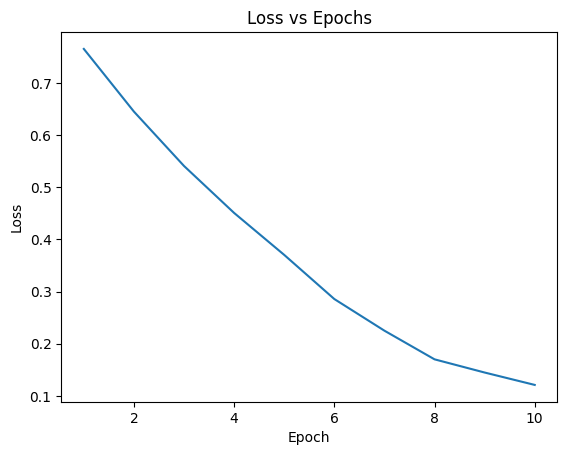

Finished Training CNN with Adams


In [ ]:
# Setting up the loss and optimizer
criterion = nn.CrossEntropyLoss()
#this is the exact same implementation as the one in Q3.7
#Since both of them uses adams
optimizer = optim.Adam(model_CNN_adams.parameters(), lr=0.001)

# Training Loop
epoch_losses = []
for epoch in range(10):  #The number of epoches can actually be optimized a bit more to 15.
#but again, we do not have time to run on this version of the code since the results
#are already shown in the report.
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = model_CNN_adams(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")


# Plotting
plt.plot(range(1, 11), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

print("Finished Training CNN with Adams")

The above takes 14 mins to train

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_CNN_adams(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test images: {100 * correct / total}%")

Accuracy of the model on the test images: 71.56%


Epoch 1, Loss: 1.8971763172417955
Epoch 2, Loss: 1.5062236116670282
Epoch 3, Loss: 1.3394227594213413
Epoch 4, Loss: 1.2285634680172366
Epoch 5, Loss: 1.141635926635674
Epoch 6, Loss: 1.0721507897157498
Epoch 7, Loss: 1.0123496820859592
Epoch 8, Loss: 0.9559292237624488
Epoch 9, Loss: 0.9066190812593836
Epoch 10, Loss: 0.864323058091771


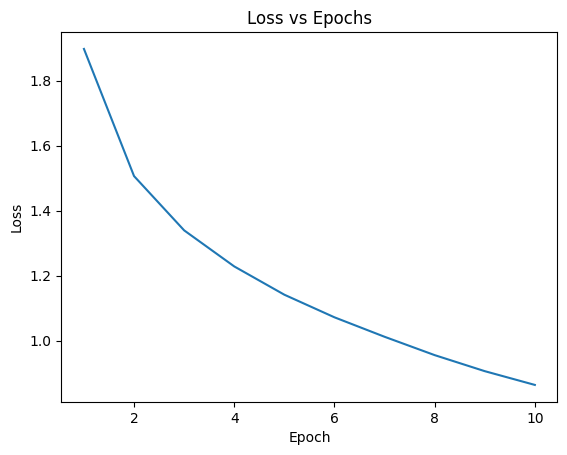

Finished Training with SGD no momentum


In [ ]:
#for SGD optimizer of 0 momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_CNN_SGD.parameters(), lr=0.01, momentum=0)

# Training Loop
epoch_losses = []
for epoch in range(10):  # Training for 10 epochs for demonstration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = model_CNN_SGD(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(trainloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")


# Plotting
plt.plot(range(1, 11), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

print("Finished Training with SGD no momentum")

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_CNN_SGD(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test images: {100 * correct / total}%")

Accuracy of the model on the test images: 61.92%


Epoch 1, Loss: 1.416222411958153
Epoch 2, Loss: 0.9871539957535541
Epoch 3, Loss: 0.815650893294293
Epoch 4, Loss: 0.673838977275602
Epoch 5, Loss: 0.5563100888334271
Epoch 6, Loss: 0.4501428570588836
Epoch 7, Loss: 0.3446544529798696
Epoch 8, Loss: 0.26519046509948074
Epoch 9, Loss: 0.20013711079859825
Epoch 10, Loss: 0.15435248146743497


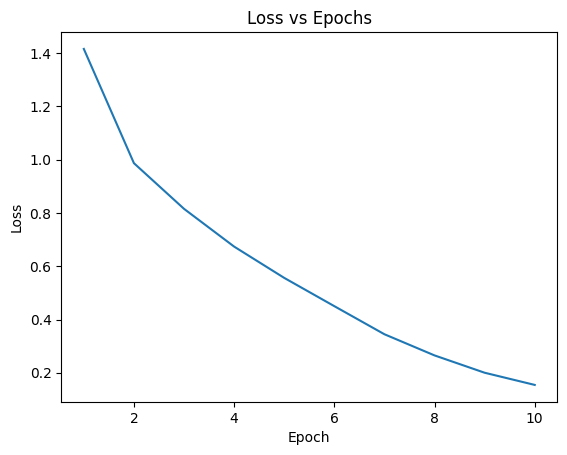

Finished Training with SGD with momentum


In [ ]:
#for the SGD with 0.9 of momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_CNN_SGD_moment.parameters(), lr=0.01, momentum=0.9)

# Training Loop
epoch_losses = []
for epoch in range(10):  # Training for 10 epochs for demonstration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = model_CNN_SGD_moment(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")


# Plotting
plt.plot(range(1, 11), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

print("Finished Training with SGD with momentum")

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_CNN_SGD_moment(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test images: {100 * correct / total}%")

Accuracy of the model on the test images: 71.48%


The most accurate CNN model is the one with the Adams Optimizer. The second highest is the one with SGD momentum of 0.9. The higher the momentum, the faster the training, the better the accuracy.

###9.
(BONUS: Counts for open-ended marks) Load a pre-trained model that you see fit (e.g., a ResNet) using PyTorch, and then freeze all the convolutional layers and remove all the fully connected ones.
Add a number of
fully connected layers of your choice right after the convolutional layers. Train only the fully connected layers
of the pre-trained model on the CIFAR-10 dataset. How does this pre-trained model compare to the best MLP
in part 1 and to the regular CNN in part 5 in terms of the accuracy? How does it compare to the previous models
in terms of the required training time? Justify your choice of how many fully connected layers that you have
added to the pre-trained model through careful experiments.

In [ ]:
import torchvision.models as models
# Load pre-trained ResNet model + higher level layers
model_ResNet = models.resnet18(pretrained=True)

# Freeze convolutional layers
for param in model_ResNet.parameters():
    param.requires_grad = False

# Check the existing architecture
print(model_ResNet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Remove fully connected layers

num_ftrs = model_ResNet.fc.in_features
#model_ResNet.fc.in_features helps access the input features of the last layers
model_ResNet.fc = nn.Identity()  # Put fc into the Identity function
#Identity function make everything that satisfies its condition 1 and everything else 0

# Add custom fully connected layers
model_ResNet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 10)  # 10 classes for CIFAR-10
)


Tried to optimize using grid search but failed

In [ ]:
'''
#we do a slight modification to the above CNN function that we have used for Q8
#for better optimization purpose.
def make_model(activation, num_neurons):
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, 3)
            self.conv2 = nn.Conv2d(32, 64, 3)
            self.fc1 = nn.Linear(64 * 6 * 6, num_neurons)
            self.fc2 = nn.Linear(num_neurons, 10)

        def forward(self, x):
            x = activation(self.conv1(x))
            x = activation(self.conv2(x))
            x = x.view(-1, 64 * 6 * 6)
            x = activation(self.fc1(x))
            x = self.fc2(x)
            return x

    return Net()

#The difinition of the convolutional net work is based on
#the official page of PyTorch and their way of defining a convolutional net wwrok
'''

In [ ]:
'''
# Define a list of activation functions
activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.Tanh(), nn.Sigmoid()]

# Define a list of number of neurons for the fully connected layer
num_neurons_list = [128, 256, 512]

#exhaustively looking for the best model for
for activation in activation_functions:
    for num_neurons in num_neurons_list:
        model = make_model(activation, num_neurons)
        optzr = optim.SGD(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()


'''

The result that was obtained with the "optimization" attemp above has an accuracy of 10.19%, which is not worth to do. So we kept the previous version

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ResNet.fc.parameters(), lr=0.001)  # Only optimize the fully connected layers

# Training loop
for epoch in range(10):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_ResNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_ResNet(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test images: {100 * correct / total}%")

Accuracy of the model on the test images: 39.15%
